# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [2]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt
import random as rn
from tensorflow import keras
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU,Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, GlobalAveragePooling3D, TimeDistributed, Conv2D, MaxPooling2D, GlobalAveragePooling2D, ConvLSTM2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

## Data generator

In [3]:
# We set the random seed so that the results don't vary drastically.
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [4]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

In [5]:
print('No of training sequences =', num_train_sequences)
print('No of validation sequences =', num_val_sequences)

No of training sequences = 663
No of validation sequences = 100


In [6]:
batch_size = 25
frames_per_video = 10
img_width = 120
img_height = 120

In [7]:
def generator(source_path, folder_list, batch_size):

    # Let's start from the 5th frame and go until the 25th frame as the initial and last frame might not contain important
    # information. Also let's take alternate of these frame. So in total we are considering (25 - 5) / 2 = 10 frames of each video
    img_idx = range(5, 26, 2)
    frames_per_video = len(img_idx)
    
    while True:
        # Shuffling the video to pick a random video, as the videos are arranged with respective to their categories
        t = np.random.permutation(folder_list)

        # There will be two batches one complete, whose size is equal to `batch_size`. Another batch will be incomplete which will
        # contain all the left over images

        # Processing for complete batch
        num_batches = len(t) // batch_size
        
        # we iterate over the number of batches
        for batch in range(num_batches):
            
            batch_data = np.zeros((batch_size, frames_per_video, img_width, img_height, 3))
            batch_labels = np.zeros((batch_size, 5))
            
            # iterate over the batch_size
            for folder in range(batch_size):
                
                # read all the images in the folder
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                                
                #  Iterate over the frames/images of a folder to read them in
                for idx, item in enumerate(img_idx):
                    # Get the single image
                    image = imread(source_path + '/'+ t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                                        
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized = resize(image, (img_width, img_height), anti_aliasing=True)
                    
                    #normalise and feed in the image
                    batch_data[folder, idx, :, :, 0] = image_resized[:, :, 0] / 255.0
                    batch_data[folder, idx, :, :, 1] = image_resized[:, :, 1] / 255.0
                    batch_data[folder, idx, :, :, 2] = image_resized[:, :, 2] / 255.0
                    
                # batch_labels are one-hot encoding of the class category
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
            
        # Processing for incomplete batch
        pending_sequence = len(t) % batch_size
        if(pending_sequence != 0):
            
            print(pending_sequence)
            print(num_batches)
            
            batch_data = np.zeros((pending_sequence, frames_per_video, img_width, img_height, 3))
            batch_labels = np.zeros((pending_sequence, 5))
            
            # iterate over the batch_size
            for folder in range(pending_sequence):
                
                # read all the images in the folder
                imgs = os.listdir(source_path + '/' + t[folder + (num_batches * batch_size)].split(';')[0])
                                
                #  Iterate over the frames/images of a folder to read them in
                for idx, item in enumerate(img_idx):
                    # Get the single image
                    image = imread(source_path + '/'+ t[folder + (num_batches * batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized = resize(image, (img_width, img_height), anti_aliasing=True)
                    
                    #normalise and feed in the image
                    batch_data[folder, idx, :, :, 0] = image_resized[:, :, 0] / 255.0
                    batch_data[folder, idx, :, :, 1] = image_resized[:, :, 1] / 255.0
                    batch_data[folder, idx, :, :, 2] = image_resized[:, :, 2] / 255.0
                    
                # batch_labels are one-hot encoding of the class category
                batch_labels[folder, int(t[folder + (num_batches * batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
input_shape=(len(range(5, 26, 2)), img_width, img_height, 3)

In [9]:
def compile_model(model, optimizer):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print(model.summary())

In [10]:
def get_callbacks(num_epochs):
    
    # Save model checkpoints
    curr_dt_time = datetime.datetime.now()
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    if not os.path.exists(model_name):
        os.mkdir(model_name)
    
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}.h5'
    checkpoint = ModelCheckpoint(filepath,
        monitor='val_loss',
        verbose=1,
        save_best_only=False,
        save_weights_only=False,
        mode='auto',
        save_freq = num_epochs
    )

    # Reduce the LR if the accuracy is not decreasing
    LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
        patience=3, 
        verbose=1, 
        factor=0.5, 
        min_lr=0.00001
    )
    
    return [LR, checkpoint]

In [11]:
def fit_model(model, num_epochs):
    # The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        
    # Initilizing generators
    train_generator = generator(train_path, train_doc, batch_size)
    val_generator = generator(val_path, val_doc, batch_size)
        
    # Fitting the model
    callbacks_list = get_callbacks(num_epochs)
    history = model.fit(train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=num_epochs,
        verbose=1, 
        callbacks=callbacks_list,
        validation_data=val_generator, 
        validation_steps=validation_steps,
        class_weight=None,
        workers=1,
        initial_epoch=0
    )
    
    return history

In [12]:
def visualize_model_performance(history, num_epochs):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

### Final model

In [13]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.3))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.3))

model.add(Conv3D(128, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(Dropout(0.3))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dense(5, activation='softmax'))

2022-11-11 04:43:44.621817: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-11-11 04:43:44.621883: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 9, 118, 118, 32)   2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 59, 59, 32)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 4, 59, 59, 32)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 1, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 1, 28, 28, 64)     0

2022-11-11 04:43:49.484943: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


25/27 [==========================>...] - ETA: 3s - loss: 1.6938 - categorical_accuracy: 0.198413
26
27/27 [==============================] - 60s 2s/step - loss: 1.6888 - categorical_accuracy: 0.1976 - val_loss: 1.6090 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
 2/27 [=>............................] - ETA: 52s - loss: 1.6021 - categorical_accuracy: 0.2200
Epoch 00002: saving model to model_init_2022-11-1104_43_46.331818/model-00002-1.60308-0.20000.h5
25/27 [==========================>...] - ETA: 3s - loss: 1.6046 - categorical_accuracy: 0.196813
26
27/27 [==============================] - 58s 2s/step - loss: 1.6044 - categorical_accuracy: 0.2006 - val_loss: 1.6073 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/30
 5/27 [====>.........................] - ETA: 36s - loss: 1.6032 - categorical_accuracy: 0.1520
Epoch 00003: saving model to model_init_2022-11-1104_43_46.331818/model-00003-1.60396-0.14667.h5
25/27 [==========================>...] - ETA: 3s - loss: 1.5

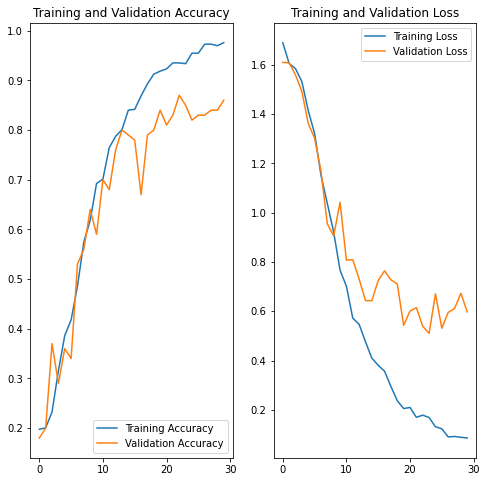

In [14]:
num_epochs = 30
optimizer = 'adam'

compile_model(model, optimizer)
history = fit_model(model, num_epochs)
visualize_model_performance(history, num_epochs)

### Experiments

#### Experiment 1 - Simple baseline model using Conv3D

In [12]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dense(5, activation='softmax'))

2022-11-10 07:50:10.025439: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-11-10 07:50:10.025527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 8, 118, 118, 32)   2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 59, 59, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 1, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 128)               6

2022-11-09 15:01:07.911170: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


25/27 [==========================>...] - ETA: 3s - loss: 1.8064 - categorical_accuracy: 0.235213
26
27/27 [==============================] - 64s 2s/step - loss: 1.7858 - categorical_accuracy: 0.2413 - val_loss: 1.4589 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/10
25/27 [==========================>...] - ETA: 3s - loss: 1.1807 - categorical_accuracy: 0.528013
26
27/27 [==============================] - 62s 2s/step - loss: 1.1713 - categorical_accuracy: 0.5354 - val_loss: 1.0452 - val_categorical_accuracy: 0.6100 - lr: 0.0010
Epoch 3/10
25/27 [==========================>...] - ETA: 3s - loss: 0.7958 - categorical_accuracy: 0.686413
26
27/27 [==============================] - 63s 2s/step - loss: 0.7889 - categorical_accuracy: 0.6923 - val_loss: 1.1638 - val_categorical_accuracy: 0.6100 - lr: 0.0010
Epoch 4/10
25/27 [==========================>...] - ETA: 3s - loss: 0.4849 - categorical_accuracy: 0.838413
26
27/27 [==============================] - 61s 2s/step - loss: 0.4845 -

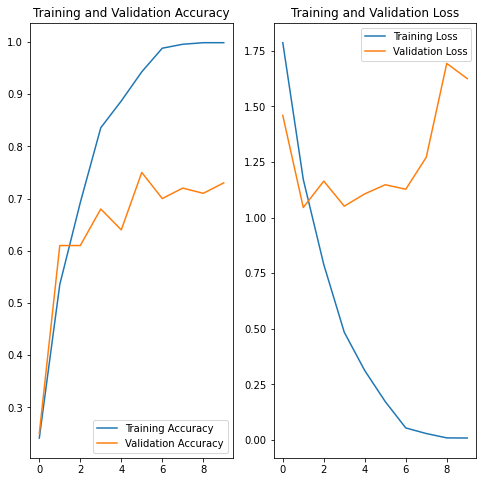

In [16]:
num_epochs = 10
optimizer = 'adam'

compile_model(model, optimizer)
history = fit_model(model, num_epochs)
visualize_model_performance(history, num_epochs)

#### Experiment 2 - Same as but with dropouts and more epochs

In [34]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape)
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dense(5, activation='softmax'))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_14 (Conv3D)          (None, 8, 118, 118, 32)   2624      
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 4, 59, 59, 32)    0         
 3D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 4, 59, 59, 32)     0         
                                                                 
 conv3d_15 (Conv3D)          (None, 2, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 1, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 1, 28, 28, 64)    

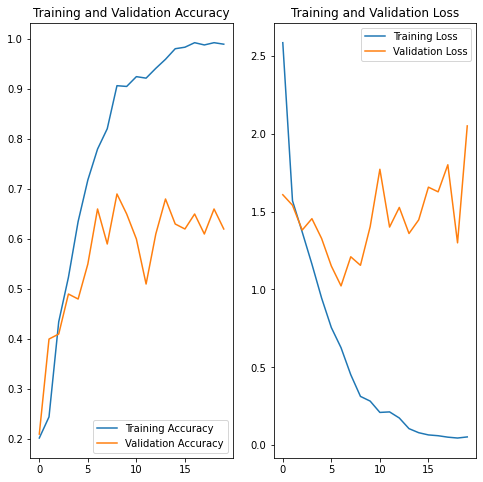

In [35]:
num_epochs = 20
optimizer = 'adam'

compile_model(model, optimizer)
history = fit_model(model, num_epochs)
visualize_model_performance(history, num_epochs)

#### Experiment 3 - Increasing the Conv3D layer

In [15]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dense(5, activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 9, 118, 118, 32)   2624      
                                                                 
 conv3d_3 (Conv3D)           (None, 7, 116, 116, 32)   27680     
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 7, 58, 58, 32)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 5, 56, 56, 64)     55360     
                                                                 
 conv3d_5 (Conv3D)           (None, 3, 54, 54, 64)     110656    
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 3, 27, 27, 64)    0         
 3D)                                                  

2022-11-10 05:02:31.330229: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


25/27 [==========================>...] - ETA: 3s - loss: 1.8234 - categorical_accuracy: 0.251213
26
27/27 [==============================] - 65s 2s/step - loss: 1.8050 - categorical_accuracy: 0.2549 - val_loss: 1.4915 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 2/10
25/27 [==========================>...] - ETA: 3s - loss: 1.3980 - categorical_accuracy: 0.412813
26
27/27 [==============================] - 59s 2s/step - loss: 1.3981 - categorical_accuracy: 0.4178 - val_loss: 1.3304 - val_categorical_accuracy: 0.4500 - lr: 0.0010
Epoch 3/10
25/27 [==========================>...] - ETA: 3s - loss: 1.3366 - categorical_accuracy: 0.476813
26
27/27 [==============================] - 58s 2s/step - loss: 1.3260 - categorical_accuracy: 0.4842 - val_loss: 1.4229 - val_categorical_accuracy: 0.4900 - lr: 0.0010
Epoch 4/10
25/27 [==========================>...] - ETA: 3s - loss: 1.0044 - categorical_accuracy: 0.622413
26
27/27 [==============================] - 60s 2s/step - loss: 1.0052 -

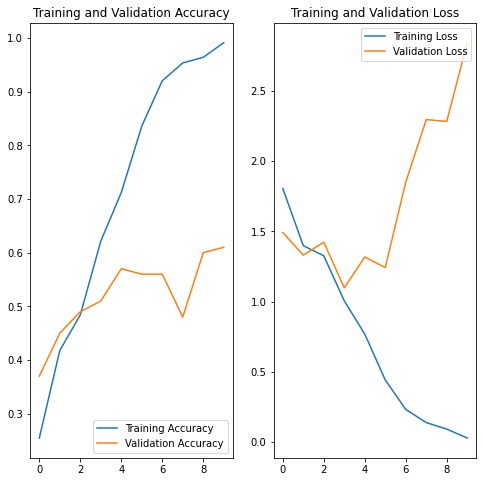

In [16]:
num_epochs = 10
optimizer = 'adam'

compile_model(model, optimizer)
history = fit_model(model, num_epochs)
visualize_model_performance(history, num_epochs)

#### Experiment 4 - Same as above but with dropouts and batch normalization

In [17]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(Dropout(0.3))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dense(5, activation='softmax'))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 9, 118, 118, 32)   2624      
                                                                 
 conv3d_7 (Conv3D)           (None, 7, 116, 116, 32)   27680     
                                                                 
 batch_normalization (BatchN  (None, 7, 116, 116, 32)  128       
 ormalization)                                                   
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 7, 58, 58, 32)    0         
 3D)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 58, 58, 32)     0         
                                                                 
 conv3d_8 (Conv3D)           (None, 5, 56, 56, 64)    

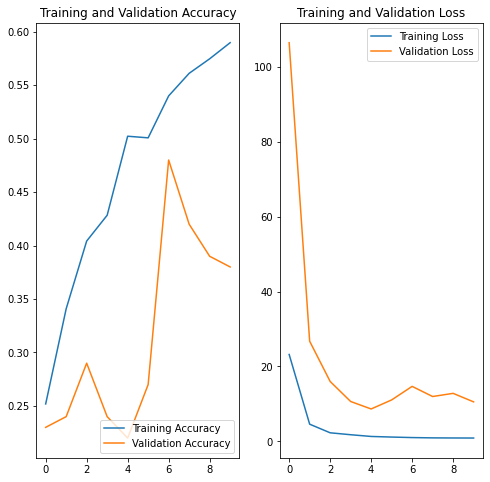

In [18]:
num_epochs = 10
optimizer = 'adam'

compile_model(model, optimizer)
history = fit_model(model, num_epochs)
visualize_model_performance(history, num_epochs)

#### Experiment 5 - Deep Conv3D layer with different neurons sizes

In [13]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.3))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.3))

model.add(Conv3D(128, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(Dropout(0.3))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dense(5, activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 9, 118, 118, 32)   2624      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 4, 59, 59, 32)    0         
 3D)                                                             
                                                                 
 dropout (Dropout)           (None, 4, 59, 59, 32)     0         
                                                                 
 conv3d_3 (Conv3D)           (None, 2, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 1, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 1, 28, 28, 64)    

2022-11-10 07:50:35.061739: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


25/27 [==========================>...] - ETA: 3s - loss: 1.6582 - categorical_accuracy: 0.203213
26
27/27 [==============================] - 62s 2s/step - loss: 1.6551 - categorical_accuracy: 0.2021 - val_loss: 1.6084 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/10
25/27 [==========================>...] - ETA: 3s - loss: 1.5984 - categorical_accuracy: 0.200013
26
27/27 [==============================] - 60s 2s/step - loss: 1.5982 - categorical_accuracy: 0.2036 - val_loss: 1.6068 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/10
25/27 [==========================>...] - ETA: 3s - loss: 1.5750 - categorical_accuracy: 0.291213
26
27/27 [==============================] - 59s 2s/step - loss: 1.5734 - categorical_accuracy: 0.2836 - val_loss: 1.5540 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 4/10
25/27 [==========================>...] - ETA: 3s - loss: 1.5223 - categorical_accuracy: 0.321613
26
27/27 [==============================] - 59s 2s/step - loss: 1.5221 -

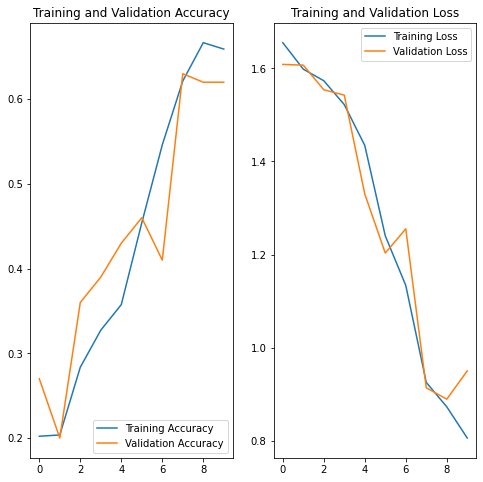

In [14]:
num_epochs = 10
optimizer = 'adam'

compile_model(model, optimizer)
history = fit_model(model, num_epochs)
visualize_model_performance(history, num_epochs)

##### Experiment 5.1 - Running with higher epochs

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 9, 118, 118, 32)   2624      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 4, 59, 59, 32)    0         
 3D)                                                             
                                                                 
 dropout (Dropout)           (None, 4, 59, 59, 32)     0         
                                                                 
 conv3d_3 (Conv3D)           (None, 2, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 1, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 1, 28, 28, 64)    

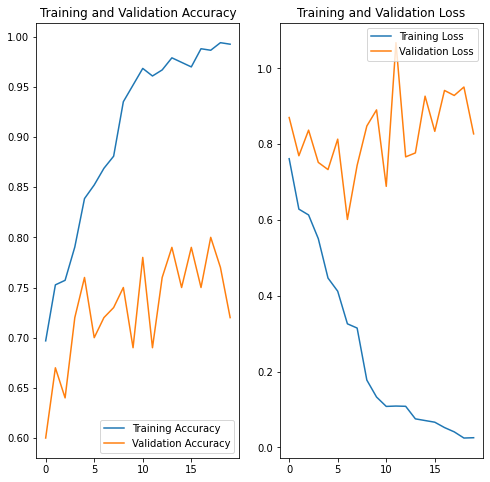

In [15]:
num_epochs = 20
optimizer = 'adam'

compile_model(model, optimizer)
history = fit_model(model, num_epochs)
visualize_model_performance(history, num_epochs)

#### Experiment 6 - Simple Con2D with GRU

In [16]:
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D(pool_size=2)))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=2)))

model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(Dense(128, activation='relu')))

model.add(GRU(128))

model.add(Dense(5, activation='softmax'))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 11, 118, 118, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 11, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 11, 57, 57, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 11, 28, 28, 64)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 11, 50176)       

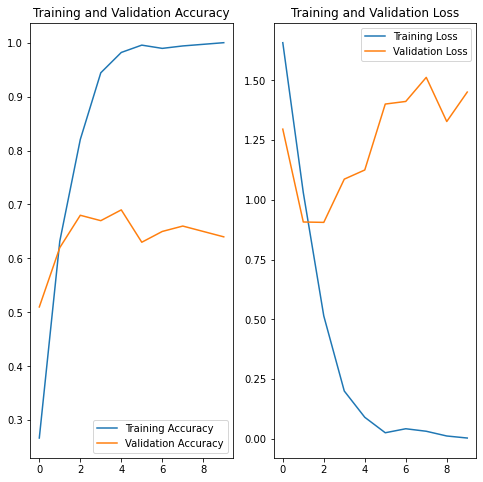

In [22]:
num_epochs = 10
optimizer = 'adam'

compile_model(model, optimizer)
history = fit_model(model, num_epochs)
visualize_model_performance(history, num_epochs)

#### Experiment 7 - Increased Conv2D layers with GRU

In [15]:
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
model.add(Dropout(0.3))

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
model.add(Dropout(0.3))

model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
model.add(Dropout(0.3))

model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(Dense(128, activation='relu')))
model.add(Dropout(0.3))

model.add(GRU(128))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 11, 118, 118, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 11, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 dropout_4 (Dropout)         (None, 11, 59, 59, 32)    0         
                                                                 
 time_distributed_2 (TimeDis  (None, 11, 57, 57, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 11, 28, 28, 64)   0         
 tributed)                                            

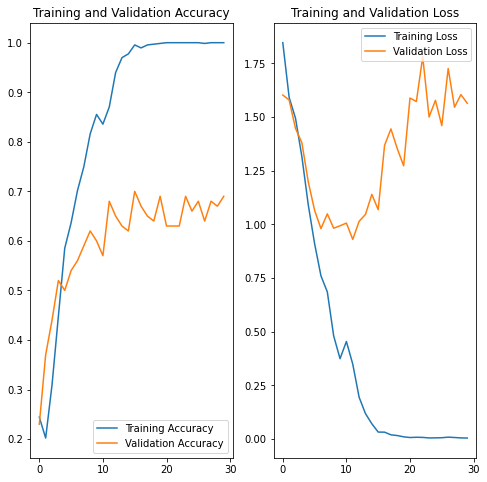

In [16]:
num_epochs = 30
optimizer = 'adam'

compile_model(model, optimizer)
history = fit_model(model, num_epochs)
visualize_model_performance(history, num_epochs)

#### Experiment 8 - Simple Conv2D layer with LSTM

In [17]:
model = Sequential()
model.add(TimeDistributed(Conv2D(8, (3, 3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D(pool_size=2)))

model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=2)))

model.add(ConvLSTM2D(32, kernel_size=3, return_sequences=False))

model.add(Flatten())
model.add(Dense(64, activation='relu'))

model.add(Dense(5, activation='softmax'))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 11, 118, 118, 8)  224       
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 11, 59, 59, 8)    0         
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 11, 57, 57, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 11, 28, 28, 16)   0         
 stributed)                                                      
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 26, 26, 32)       

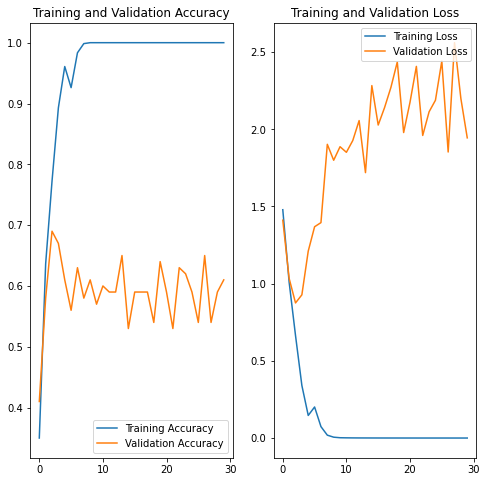

In [18]:
num_epochs = 30
optimizer = 'adam'

compile_model(model, optimizer)
history = fit_model(model, num_epochs)
visualize_model_performance(history, num_epochs)

#### Experiment 9 - Dense Conv2D + LSTM

In [13]:
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
model.add(Dropout(0.3))

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
model.add(Dropout(0.3))

model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
model.add(Dropout(0.3))

model.add(ConvLSTM2D(32, kernel_size=3, return_sequences=False))

model.add(Flatten())
model.add(Dense(64, activation='relu'))

model.add(Dense(5, activation='softmax'))

2022-11-10 16:41:47.836642: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-11-10 16:41:47.836709: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3d:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 11, 118, 118, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 11, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 dropout (Dropout)           (None, 11, 59, 59, 32)    0         
                                                                 
 time_distributed_2 (TimeDis  (None, 11, 57, 57, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 11, 28, 28, 64)   0         
 tributed)                                              

2022-11-10 16:42:05.412298: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


25/27 [==========================>...] - ETA: 3s - loss: 1.6387 - categorical_accuracy: 0.185613
26
27/27 [==============================] - 62s 2s/step - loss: 1.6366 - categorical_accuracy: 0.1855 - val_loss: 1.6062 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
25/27 [==========================>...] - ETA: 3s - loss: 1.5486 - categorical_accuracy: 0.294413
26
27/27 [==============================] - 58s 2s/step - loss: 1.5422 - categorical_accuracy: 0.2971 - val_loss: 1.9313 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/30
25/27 [==========================>...] - ETA: 3s - loss: 1.3631 - categorical_accuracy: 0.430413
26
27/27 [==============================] - 57s 2s/step - loss: 1.3562 - categorical_accuracy: 0.4359 - val_loss: 1.5125 - val_categorical_accuracy: 0.4000 - lr: 0.0010
Epoch 4/30
25/27 [==========================>...] - ETA: 3s - loss: 1.0213 - categorical_accuracy: 0.588813
26
27/27 [==============================] - 58s 2s/step - loss: 1.0220 -

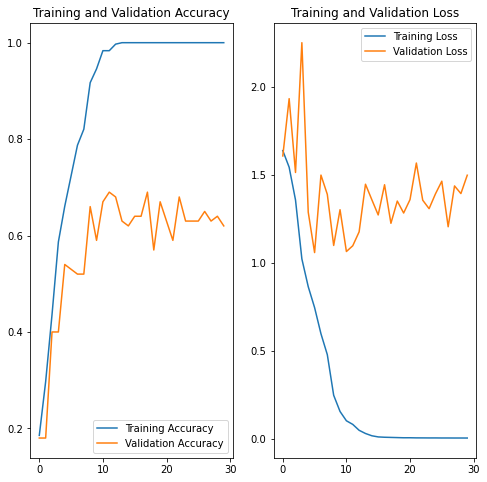

In [14]:
num_epochs = 30
optimizer = 'adam'

compile_model(model, optimizer)
history = fit_model(model, num_epochs)
visualize_model_performance(history, num_epochs)